In [1]:
# This is version 3.10 for smFISH spot detection. 
# I will also have a pycharm version for running stably on northwestern quest with compatible bash command. 
# For Researchers not familiar with coding 
# I will further provide a GUI version in version 3.2+
# To Set up you need package stardist and bigfish/fishquant. 
# This requires a enviornment and setting parameters. 
# https://stackoverflow.com/questions/58645807/change-interpreter-in-jupyter-notebook Please refer to this for setting up python interpreter. 
# This requires setting up a enviornment for 3D detection on stardist and bigfish. 
# Recommend to setup a enviornment for Stardist and then install bigfish/fishquant. 
# Please also make sure if you are running on apple silicon
# Make sure your tensorflow is supported by tensorflow metal. 
# https://pypi.org/project/tensorflow-metal/ Here find the compatible versions.
# Please read instructions from Stardist to do so, and set python interpreter using the stackoverflow instructions. 
# Depend on your Image and settings this whole code need a while to run. I am making it as light as possible so please be patient. 
# I am also using tqdm in all of my customized code to show you process and the expected time in real time. 
# Please contact qingxuguan2020@u.northwestern.edu for any details/updates/help. 

In [1]:
# Setting up Your Conditions
# Setting Path
controlDirectory = None 
experimentDirectory = "/Users/eliasguan/Desktop/EG_1112_WntP2" 
customFileName = "565.tif"
counterstainDirectory = "/Users/eliasguan/Desktop/EG_1112_WntP2" 
counterstainFileName = "633.tif"

In [2]:
# Setting parameters
kernel_size = (1,1.5,1.5)
# Set the voxel size. This is determined by the pixel size of your microscope. Please contact microscopt manufactuer and convert resolution to voxel size. 
# unit is nm, please change to nm and note this should be the same for control and your experimental image. 
# I specifically allow this code to run different voxel size for control and experimental image, but for a good experiment you should not do it like that. 
control_voxel_size = (361,75,75)
voxel_size = (361,75,75)
minimal_distance = (2,2,2)
# Set the spot size as your expected spot size 
spot_size = (600, 300, 300)
saveSpotInformation = True
counterstain = True

In [3]:
# Importing packages 
import glob
import os 
import bigfish.detection 
import bigfish.plot
import tifffile
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Here load functions 
# Function1 : Finding all file path
def find_tif_files(directory, pattern="565.tif"):
    matches = []
    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(pattern):
                matches.append(os.path.join(root, file))
    return matches
def create_folder_in_same_directory(file_path, folder_name):
    """
    Creates a folder with the specified name in the same directory as the given file.
    If the folder already exists, it returns the existing path.
    """
    # Get the directory of the given file
    directory = os.path.dirname(file_path)
    
    # Define the path for the specified folder
    folder_path = os.path.join(directory, folder_name)
    
    # Check if the folder exists
    if not os.path.exists(folder_path):
        # Create the folder if it doesn't exist
        os.makedirs(folder_path)
        print(f"Created '{folder_name}' folder at: {folder_path}")
    else:
        print(f"'{folder_name}' folder already exists at: {folder_path}")
    
    return folder_path

In [5]:
# If you have control image then read in control images 
if controlDirectory:
    # Create threshold storage 
    controlThresholdCollection = []
    # Finding all tif files in your directory
    controlsmFISHChannelPaths = find_tif_files(controlDirectory,customFileName)
    for i in tqdm(range(len(controlsmFISHChannelPaths))):
        # Get your directory of each single file 
        file_directory = os.path.dirname(controlsmFISHChannelPaths[i])
        # Move to current work directory
        os.chdir(file_directory)
        # Create results folder
        create_folder_in_same_directory(".","results")
        # Aim to save everything in results folder
        os.chdir("results")
        # Read in image
        controlsmFISHChannel = tifffile.imread(controlsmFISHChannelPaths[i])
        # Main Detection function 
        control_spots, control_spots_threshold = bigfish.detection.detect_spots(
                images=controlsmFISHChannel,
                return_threshold=True,
                voxel_size= voxel_size,  # in nanometer (one value per dimension zyx)
                spot_radius= spot_size, # in nanometer (one value per dimension zyx)
                log_kernel_size= kernel_size,
                minimum_distance= minimal_distance)
        # Plot the elbow curve to make sure you have it saved. 
        bigfish.plot.plot_elbow(
                images=controlsmFISHChannel,
                voxel_size=voxel_size,
                spot_radius=spot_size,
                path_output="Elbow.png",
                show=False)
        # Add the threshold to your storage
        controlThresholdCollection.append(control_spots_threshold)
        # Print out the threshold
        print("threshold: {0}".format(control_spots_threshold))

In [6]:
# Create your collection for experiment group thresholds
experimentThresholdCollection = []
#  Find all files for your experiment group
experimentsmFISHChannelPaths = find_tif_files(experimentDirectory, customFileName)
for i in tqdm(range(len(experimentsmFISHChannelPaths))):
    # Same as previous code. 
    file_directory = os.path.dirname(experimentsmFISHChannelPaths[i])
    os.chdir(file_directory)
    create_folder_in_same_directory(".","results")
    os.chdir("results")
    experimentsmFISHChannel = tifffile.imread(experimentsmFISHChannelPaths[i])
    # Function to find your spots and threshold 
    experiment_spots, experiment_spots_threshold = bigfish.detection.detect_spots(
            images=experimentsmFISHChannel,
            return_threshold=True,
            voxel_size= voxel_size,  # in nanometer (one value per dimension zyx)
            spot_radius= spot_size, # in nanometer (one value per dimension zyx)
            log_kernel_size= kernel_size,
            minimum_distance= minimal_distance)
    # Plot your elbow curve
    bigfish.plot.plot_elbow(
            images=experimentsmFISHChannel,
            voxel_size=voxel_size,
            spot_radius=spot_size,
            path_output="Elbow.png",
            show=False)
    # Add your threshold to your collection 
    experimentThresholdCollection.append(experiment_spots_threshold)
    # Save the spots here for future works. 
    print("threshold: {0}".format(experiment_spots_threshold))
    if saveSpotInformation == True:
         with open ("spot_info.txt","w") as file :
             file.write("\r shape: {0}".format(experiment_spots.shape))
             file.write("\r dtype: {0}".format(experiment_spots.dtype))
             file.write("\r threshold: {0}".format(experiment_spots_threshold))

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Created 'results' folder at: results


 20%|█████████                                    | 1/5 [01:14<04:56, 74.12s/it]

threshold: 13.151515151515152
Created 'results' folder at: results


 40%|██████████████████                           | 2/5 [02:30<03:46, 75.39s/it]

threshold: 11.0
Created 'results' folder at: results


 60%|███████████████████████████                  | 3/5 [03:47<02:32, 76.39s/it]

threshold: 12.121212121212121
Created 'results' folder at: results


 80%|████████████████████████████████████         | 4/5 [05:04<01:16, 76.31s/it]

threshold: 12.080808080808081
Created 'results' folder at: results


100%|█████████████████████████████████████████████| 5/5 [06:23<00:00, 76.61s/it]

threshold: 11.878787878787879


In [7]:
if controlDirectory:
    thresholds = [controlThresholdCollection, experimentThresholdCollection]
    labels = ['control group Threshold', "Experiment group Threshold"]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=thresholds)
    
    # Add title
    plt.title("Threshold for Spot Detection")
    
    # Calculate and annotate mean values
    for i, dataset in enumerate(thresholds):
        mean_value = np.mean(dataset)
        plt.text(i, mean_value, f'Mean: {mean_value:.2f}', 
                 ha='center', va='bottom', color='black')
    
    # Set x-ticks
    plt.xticks(ticks=[0, 1], labels=labels)
    
    # Display the plot
    plt.show()

In [24]:
# Create your collection for counterstain group thresholds
if counterstain:
    counterstainThresholdCollection = []
    #  Find all files for your counterstain group
    counterstainsmFISHChannelPaths = find_tif_files(counterstainDirectory, counterstainFileName)
    for i in tqdm(range(len(counterstainsmFISHChannelPaths))):
        # Same as previous code. 
        file_directory = os.path.dirname(counterstainsmFISHChannelPaths[i])
        os.chdir(file_directory)
        create_folder_in_same_directory(".","results")
        os.chdir("results")
        counterstainsmFISHChannel = tifffile.imread(counterstainsmFISHChannelPaths[i])
        # Function to find your spots and threshold 
        counterstain_spots, counterstain_spots_threshold = bigfish.detection.detect_spots(
                images=counterstainsmFISHChannel,
                return_threshold=True,
                voxel_size= voxel_size,  # in nanometer (one value per dimension zyx)
                spot_radius= spot_size, # in nanometer (one value per dimension zyx)
                log_kernel_size= kernel_size,
                minimum_distance= minimal_distance)
        # Plot your elbow curve
        bigfish.plot.plot_elbow(
                images=counterstainsmFISHChannel,
                voxel_size=voxel_size,
                spot_radius=spot_size,
                path_output="Elbow.png",
                show=False)
        # Add your threshold to your collection 
        counterstainThresholdCollection.append(counterstain_spots_threshold)
        # Save the spots here for future works. 
        print("threshold: {0}".format(counterstain_spots_threshold))

  0%|                                                     | 0/5 [00:00<?, ?it/s]

'results' folder already exists at: results


 20%|█████████                                    | 1/5 [01:10<04:41, 70.27s/it]

threshold: 7.353535353535354
Created 'results' folder at: results


 40%|██████████████████                           | 2/5 [02:25<03:39, 73.19s/it]

threshold: 7.0
Created 'results' folder at: results


 60%|███████████████████████████                  | 3/5 [03:33<02:22, 71.00s/it]

threshold: 7.0
Created 'results' folder at: results


 80%|████████████████████████████████████         | 4/5 [04:42<01:10, 70.05s/it]

threshold: 7.0
Created 'results' folder at: results


100%|█████████████████████████████████████████████| 5/5 [05:56<00:00, 71.39s/it]

threshold: 7.0


In [23]:
if controlDirectory:
    thresholds = [controlThresholdCollection, experimentThresholdCollection, counterstainThresholdCollection]
    labels = ['control group Threshold', "Experiment group Threshold", "Counterstain Threshold"]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=thresholds)
    
    # Add title
    plt.title("Threshold for Spot Detection")
    
    # Calculate and annotate mean values
    for i, dataset in enumerate(thresholds):
        mean_value = np.mean(dataset)
        plt.text(i, mean_value, f'Mean: {mean_value:.2f}', 
                 ha='center', va='bottom', color='black')
    
    # Set x-ticks
    plt.xticks(ticks=[0, 1, 2], labels=labels)
    
    # Display the plot
    plt.show()

In [22]:
# Create your collection for counterstain group thresholds
if counterstain and controlDirectory: 
    counterstainControlThresholdCollection = []
    #  Find all files for your counterstain group
    counterstainControlsmFISHChannelPaths = find_tif_files(controlDirectory, counterstainFileName)
    for i in tqdm(range(len(counterstainControlsmFISHChannelPaths))):
        # Same as previous code. 
        file_directory = os.path.dirname(counterstainControlsmFISHChannelPaths[i])
        os.chdir(file_directory)
        create_folder_in_same_directory(".","results")
        os.chdir("results")
        counterstainControlsmFISHChannel = tifffile.imread(counterstainControlsmFISHChannelPaths[i])
        # Function to find your spots and threshold 
        counterstainControl_spots, counterstainControl_spots_threshold = bigfish.detection.detect_spots(
                images=counterstainControlsmFISHChannel,
                return_threshold=True,
                voxel_size= voxel_size,  # in nanometer (one value per dimension zyx)
                spot_radius= spot_size, # in nanometer (one value per dimension zyx)
                log_kernel_size= kernel_size,
                minimum_distance= minimal_distance)
        # Plot your elbow curve
        bigfish.plot.plot_elbow(
                images=counterstainControlsmFISHChannel,
                voxel_size=voxel_size,
                spot_radius=spot_size,
                path_output="Elbow.png",
                show=False)
        # Add your threshold to your collection 
        counterstainControlThresholdCollection.append(counterstainControl_spots_threshold)
        # Save the spots here for future works. 
        print("threshold: {0}".format(counterstainControl_spots_threshold))

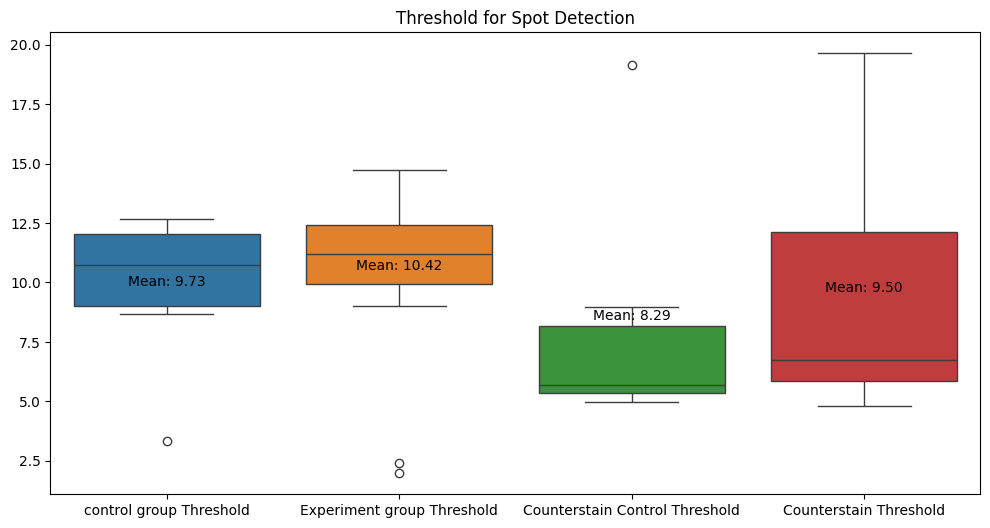

In [16]:
if counterstain and controlDirectory: 
    thresholds = [controlThresholdCollection, experimentThresholdCollection, counterstainControlThresholdCollection, counterstainThresholdCollection]
    labels = ['control group Threshold', "Experiment group Threshold", "Counterstain Control Threshold", "Counterstain Threshold"]
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=thresholds)
    
    # Add title
    plt.title("Threshold for Spot Detection")
    
    # Calculate and annotate mean values
    for i, dataset in enumerate(thresholds):
        mean_value = np.mean(dataset)
        plt.text(i, mean_value, f'Mean: {mean_value:.2f}', 
                 ha='center', va='bottom', color='black')
    
    # Set x-ticks
    plt.xticks(ticks=[0, 1, 2, 3], labels=labels)
    plt.savefig("thresholds.png")
    # Display the plot
    plt.show()

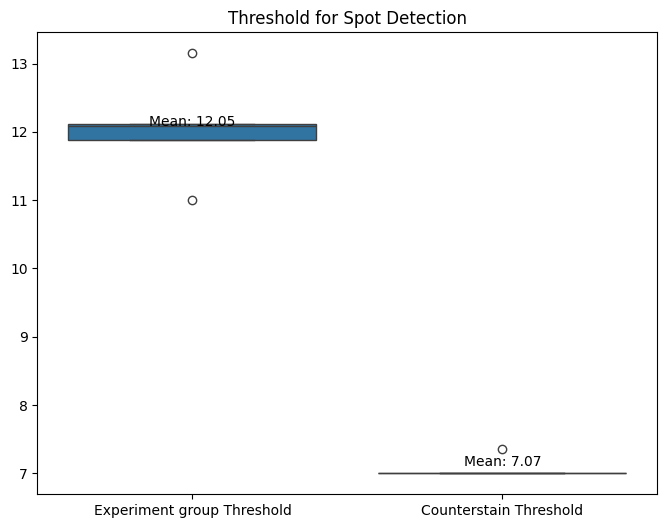

In [26]:
if not controlDirectory and counterstain:
    thresholds = [experimentThresholdCollection, counterstainThresholdCollection]
    labels = ["Experiment group Threshold", "Counterstain Threshold"]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=thresholds)
    
    # Add title
    plt.title("Threshold for Spot Detection")
    
    # Calculate and annotate mean values
    for i, dataset in enumerate(thresholds):
        mean_value = np.mean(dataset)
        plt.text(i, mean_value, f'Mean: {mean_value:.2f}', 
                 ha='center', va='bottom', color='black')
    
    # Set x-ticks
    plt.xticks(ticks=[0, 1], labels=labels)
    
    # Display the plot
    plt.show()